<a href="https://colab.research.google.com/github/xDocka15/MPA-MLF_Dockal/blob/main/MLF_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
!pip install keras-tuner --quiet

# Imports
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
import os
from tensorflow.keras.layers import Input

from kerastuner.tuners import RandomSearch
from kerastuner.tuners import Hyperband
from tensorflow.keras.layers import BatchNormalization
from keras_tuner import BayesianOptimization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import regularizers



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
        ID  target
0        0       0
1        1       0
2        2       0
3        3       0
4        4       0
...    ...     ...
1486  1486       0
1487  1487       1
1488  1488       0
1489  1489       0
1490  1490       0

[1491 rows x 2 columns]
[[-25.30056666 -34.54445688 -44.03216144 ... -33.43543411 -42.21318327
  -44.20080567]
 [-37.21657168 -28.83796589 -45.97329178 ... -34.13235963 -30.72768686
  -41.97746687]
 [-34.31051981 -38.17045981 -44.83255253 ... -34.5931764  -46.7704932
  -58.31586657]
 ...
 [-24.81139496 -24.35527671 -40.74519981 ... -11.69126833 -52.23467135
  -61.16893254]
 [-33.45241254 -33.25408695 -41.33245363 ... -34.77979018 -40.67456753
  -54.4493282 ]
 [-30.01098193 -26.85445864 -32.99086054 ... -34.30945241 -51.58250692
  -59.80397625]]
(72, 48)


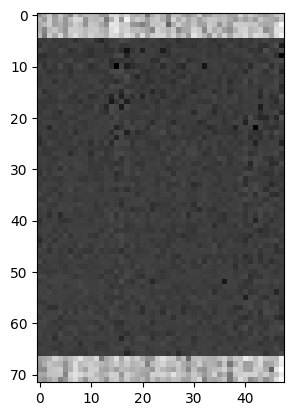

Min: -61.16893254149212
Max: 19.670490087247735
['0.npy', '1.npy', '2.npy', '3.npy', '4.npy', '5.npy', '6.npy', '7.npy', '8.npy', '9.npy']


In [110]:
# Mount Google Drive
drive.mount('/content/drive')

# file paths
label_path = '/content/drive/MyDrive/MPA-MLF_DATA_NEW/label_train.csv'
npy_path = '/content/drive/MyDrive/MPA-MLF_DATA_NEW/Train'

# Load CSV file of labels for training
pd_dataset_train_label = pd.read_csv(label_path)
print(pd_dataset_train_label)

# load npy files for training
files = sorted([f for f in os.listdir(npy_path)], key=lambda f: int(f.replace('.npy', '')))

file_path = os.path.join(npy_path, files[426])  # Create the full path to the .npy file
data = np.load(file_path)

# print data
print(data)
print(data.shape)

# plotting 2D graph of values from one file
plt.imshow(data, cmap='binary')  # 'binary' gives a two-color map (black and white)
plt.show()

# checking for a range
print("Min:", data.min())
print("Max:", data.max())

# showing how the npy train data are in the files:
print(files[:10])

In [111]:
# preparing list for the files from the Train folder
# Load each file and collect into a list
X_train = [np.load(os.path.join(npy_path, f)) for f in files]
# stack into array
X_train = np.stack(X_train)

# showing shape of X_train
print(X_train.shape)

# Flatten: (1491, 72, 48) → (1491, 72 * 48)
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Standardize
scaler = StandardScaler()
X_scaled_flat = scaler.fit_transform(X_train_flat)

# Reshape back: (1491, 72, 48)
X_scaled = X_scaled_flat.reshape(X_train.shape)

# showing shape of X_train scaled back after standardize
print(X_scaled.shape)

# hot end encode for labels
train_labels_encoded = pd.get_dummies(pd_dataset_train_label, columns=['target'])
train_labels_encoded = train_labels_encoded.astype(int)
train_labels_encoded = train_labels_encoded.drop(columns=['ID'])

# show encoded targets
print(train_labels_encoded)

(1491, 72, 48)
(1491, 72, 48)
      target_0  target_1  target_2
0            1         0         0
1            1         0         0
2            1         0         0
3            1         0         0
4            1         0         0
...        ...       ...       ...
1486         1         0         0
1487         0         1         0
1488         1         0         0
1489         1         0         0
1490         1         0         0

[1491 rows x 3 columns]


In [ ]:
# model architecture - first structure:
#model = Sequential()
#model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(72, 48, 1)))
#model.add(MaxPooling2D((2, 2)))
#model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(MaxPooling2D((2, 2)))
#model.add(Flatten())
#model.add(Dense(64, activation='relu'))
#model.add(Dense(3, activation='softmax'))

# delete previous tuning
import shutil
shutil.rmtree('tuning_dir/cnn_tuning', ignore_errors=True)

#definition of model in a function for using in hyperparameter tuning
def build_model(hp):
    model = Sequential()

    #kernel_regularizer=keras.regularizers.l2(hp.Float('l2', 1e-5, 1e-2, sampling='log'))

    model.add(Input(shape=(72, 48, 1)))

    model.add(Conv2D(
        filters=hp.Choice('conv1_filters', values=[16, 32, 64, 128]),
        kernel_size=(3, 3),
        activation='relu',
        kernel_regularizer=regularizers.l2(
        hp.Float('l2', 1e-5, 1e-2, sampling='log')
    )
    ))
    model.add(MaxPooling2D((2, 2)))

    if hp.Boolean('use_batchnorm_first'):
        model.add(BatchNormalization())


    # Optional second conv layer
    if hp.Boolean('use_second_conv'):
        model.add(Conv2D(
            filters=hp.Choice('conv2_filters', [16, 32, 64, 128]),
            kernel_size=(3, 3),
            activation='relu',
            kernel_regularizer=regularizers.l2(
        hp.Float('l2', 1e-5, 1e-2, sampling='log')
    )
        ))
        model.add(MaxPooling2D((2, 2)))

    if hp.Boolean('use_batchnorm_second'):
        model.add(BatchNormalization())

            # Optional third conv layer
    if hp.Boolean('use_third_conv'):
        model.add(Conv2D(
            filters=hp.Choice('conv3_filters', [16, 32, 64, 128]),
            kernel_size=(3, 3),
            activation='relu',
            kernel_regularizer=regularizers.l2(
        hp.Float('l2', 1e-5, 1e-2, sampling='log')
    )
        ))
        model.add(MaxPooling2D((2, 2)))

    if hp.Boolean('use_batchnorm_third'):
        model.add(BatchNormalization())

    if hp.Boolean('use_gap'):
        model.add(GlobalAveragePooling2D())
    else:
        model.add(Flatten())

    model.add(Dense(
        units=hp.Choice('dense_units', values=[16, 32, 64, 128]),
        activation='relu',
        kernel_regularizer=regularizers.l2(
        hp.Float('l2', 1e-5, 1e-2, sampling='log')
    )
    ))

    if hp.Boolean('use_second_dense'):
        model.add(Dense(units=hp.Choice('dense2_units', [16, 32, 64, 128]), activation='relu'))

    # Optional dropout
    if hp.Boolean('use_dropout'):
        model.add(Dropout(rate=hp.Float('dropout_rate', 0.1, 0.5, step=0.1)))

    model.add(Dense(3, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# tuner to get the hyperparameters:
#tuner = RandomSearch(
#    build_model,
#    objective='val_accuracy',
#    max_trials=20,
#    directory='tuning_dir',
#    project_name='cnn_tuning'
#)


#tuner = Hyperband(
#    build_model,
#    objective='val_loss',
#    max_epochs=20,
#    factor=5,  # Optional: controls early-stopping aggressiveness
#    directory='tuning_dir',
#    project_name='cnn_tuning'
#)

tuner = BayesianOptimization(
    build_model,  # your model-building function
    objective='val_loss',  # or 'val_loss', etc.
    max_trials=20,             # total number of different hyperparameter combinations to try
    num_initial_points=5,      # number of random trials before Bayesian optimization kicks in
    directory='tuning_dir',    # where to store results
    project_name='cnn_bayes'   # name of the project/folder
)

# run the tuner
tuner.search(
    X_scaled.reshape(-1, 72, 48, 1),  # Reshaping your data to match the input
    train_labels_encoded,
    epochs=20,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2)],
    batch_size=64,
    verbose=2
)

# printing the tuned hyperparameters of the model:
best_hps = tuner.get_best_hyperparameters(1)[0]
print("\nBest Hyperparameters:")
for hp_name in best_hps.values.keys():
    print(f"{hp_name}: {best_hps.get(hp_name)}")

#print("Best conv1_filters:", best_hps.get('conv1_filters'))
#print("Best conv2_filters:", best_hps.get('conv2_filters'))
#print("Best dense_units:", best_hps.get('dense_units'))
#print("Best learning rate:", best_hps.get('lr'))

best_model = tuner.get_best_models(1)[0]
best_model.summary()

Trial 15 Complete [00h 01m 18s]
val_accuracy: 0.9899665713310242

Best val_accuracy So Far: 0.9966555237770081
Total elapsed time: 00h 28m 11s

Search: Running Trial #16

Value             |Best Value So Far |Hyperparameter
128               |128               |conv1_filters
0.00046421        |6.005e-05         |l2
False             |False             |use_batchnorm_first
True              |True              |use_second_conv
False             |False             |use_batchnorm_second
False             |False             |use_third_conv
False             |False             |use_batchnorm_third
False             |False             |use_gap
16                |32                |dense_units
True              |True              |use_second_dense
True              |False             |use_dropout
0.0001            |0.001             |lr
16                |16                |conv2_filters
128               |64                |conv3_filters
0.5               |0.4               |dropout_rate
16  

In [ ]:
# feeding to the model
history = best_model.fit(X_scaled, train_labels_encoded, epochs=10, batch_size=64, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=2)], verbose=2)

In [ ]:
# Final training accuracy
final_train_acc = history.history['accuracy'][-1]

# Final validation accuracy
final_val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [ ]:
# loading Test data

# file paths
npy_path1 = '/content/drive/MyDrive/MPA-MLF_DATA_NEW/Test'

#sort and load all files from the Test folder
files_test = sorted([f for f in os.listdir(npy_path1)], key=lambda f: int(f.replace('.npy', '')))
# Load each file and collect into a list
X_test = [np.load(os.path.join(npy_path1, f)) for f in files_test]
# stack into array
X_test = np.stack(X_test)

# showing shape of X_train
print(X_test.shape)

# Flatten: (1491, 72, 48) → (1491, 72 * 48)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Standardize
scaler = StandardScaler()
X_scaled_flat_test = scaler.fit_transform(X_test_flat)

# Reshape back: (1491, 72, 48)
X_scaled_test = X_scaled_flat_test.reshape(X_test.shape)

# showing shape of X_train scaled back after standardize
print(X_scaled_test.shape)

In [ ]:
predictions = model.predict(X_scaled_test)

# Get predicted class indices
predicted_classes = np.argmax(predictions, axis=1)

# View them
print(predicted_classes)
print(predictions)

In [ ]:



# Convert filenames to IDs
ids = [int(f.replace('.npy', '')) for f in files_test]
predicted_classes = np.array(predicted_classes).flatten()

# Create submission DataFrame
submission_df = pd.DataFrame({
    'ID': ids,
    'target': predicted_classes
})

# Sort by ID (optional but tidy)
submission_df = submission_df.sort_values(by='ID')

# Save with correct format
submission_df.to_csv('submission.csv', index=False)

# Optional: download in Colab
from google.colab import files
files.download('submission.csv')